<a href="https://colab.research.google.com/github/Lindakk/Coronavirus-tweets-NLP-Text-Classification/blob/main/Text-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install -U transformers
#!pip install -U acceerate
##!pip install -U datasets
#!pip install -U bertviz
#!pip install -U umap-learn

In [ ]:
import pandas as pd
import zipfile
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
with zipfile.ZipFile('/content/Corona_NLP_train.csv.zip','r') as zip:
  zip.extractall('/content')

In [ ]:
df_train=pd.read_csv('/content/Corona_NLP_train.csv',encoding='latin1')
df_test=pd.read_csv('/content/Corona_NLP_test.csv', encoding='latin1')

In [ ]:
df_train.isnull().sum()

,0
UserName,0
ScreenName,0
Location,8590
TweetAt,0
OriginalTweet,0
Sentiment,0


In [ ]:
df_train.drop_duplicates(subset='OriginalTweet',inplace=True)

In [ ]:
df_train = df_train[['OriginalTweet', 'Sentiment']].rename(columns={'OriginalTweet': 'tweets', 'Sentiment': 'sentiment'})
df_test = df_test[['OriginalTweet', 'Sentiment']].rename(columns={'OriginalTweet': 'tweets', 'Sentiment': 'sentiment'})
label_mapping = {
    'Extremely Positive':4,
    'Positive': 3,
    'Neutral': 2,
    'Negative': 1,
    'Extremely Negative':0

}
df_train['label']=df_train.sentiment.map(label_mapping)
df_train.head()

,tweets,sentiment,label
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,2
1,advice Talk to your neighbours family to excha...,Positive,3
2,Coronavirus Australia: Woolworths to give elde...,Positive,3
3,My food stock is not the only one which is emp...,Positive,3
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0


In [ ]:
def convert_to_lower(text):
    return text.lower()

def remove_emojis(text):
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r"<.*?>","",text)


    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)


    return wierd_pattern.sub(r'', text)

def remove_punctuation(text):
    # Remove punctuation and carriage return/newline characters
    cleaned_text = re.sub(r'[^\w\s]+|[\r\n]', '', text)
    return cleaned_text

def remove_extra_white_spaces(text):
    clean_text=text.strip()
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=clean_text)
    return without_sc

def preprocessText(text):
  return remove_extra_white_spaces(remove_punctuation(remove_emojis(convert_to_lower(text))))

df_train['tweets'] = df_train['tweets'].apply(preprocessText)
df_test['tweets'] = df_test['tweets'].apply(preprocessText)

Text(0.5, 1.0, 'Frequency of Classes')

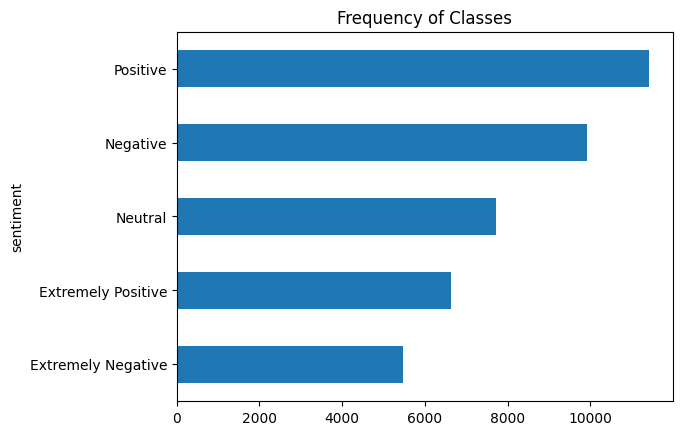

In [ ]:
lable_counts=df_train['sentiment'].value_counts(ascending=True)
lable_counts.plot(kind='barh')
plt.title('Frequency of Classes')

In [ ]:
df_train['Words per tweet']=df_train['tweets'].str.split().apply(len)

(array([1, 2, 3, 4, 5]),
 [Text(1, 0, 'Extremely Negative'),
  Text(2, 0, 'Extremely Positive'),
  Text(3, 0, 'Negative'),
  Text(4, 0, 'Neutral'),
  Text(5, 0, 'Positive')])

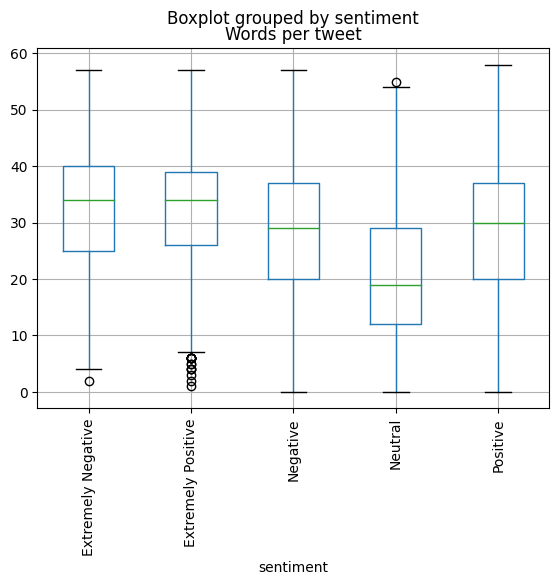

In [ ]:
df_train.boxplot('Words per tweet',by='sentiment')
plt.xticks(rotation=90)

In [ ]:
from transformers import AutoTokenizer
model_ckpt='bert-base-uncased'
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(df_train,test_size=0.3,stratify=df_train.sentiment)
test, val=train_test_split(test,test_size=1/3,stratify=test.sentiment)

In [ ]:
train.shape,test.shape,val.shape

((28809, 4), (8232, 4), (4116, 4))

In [ ]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.7 MB/s eta 0:00:00


In [ ]:
from datasets import Dataset, DatasetDict
dataset=DatasetDict(
    {'train':Dataset.from_pandas(train,preserve_index=False),
     'test':Dataset.from_pandas(test,preserve_index=False),
     'validation':Dataset.from_pandas(val,preserve_index=False)
     }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['tweets', 'sentiment', 'label', 'Words per tweet'],
        num_rows: 28809
    })
    test: Dataset({
        features: ['tweets', 'sentiment', 'label', 'Words per tweet'],
        num_rows: 8232
    })
    validation: Dataset({
        features: ['tweets', 'sentiment', 'label', 'Words per tweet'],
        num_rows: 4116
    })
})

In [ ]:
dataset['train'][0],dataset['train'][1]

({'tweets': 'the struggle is real itscoronatime toiletpaper toiletpapercrisis coronavirus over40andfabulous comedy kevinhart genx socialdistancing athome boredaf',
  'sentiment': 'Negative',
  'label': 1,
  'Words per tweet': 15},
 {'tweets': 'looking for better way to keep your hands clean california baby makes powerful plantbased hand sanitizer that kills 999 of germsâwithout harmful chemicals sanitizer covid19 coronavirus',
  'sentiment': 'Extremely Positive',
  'label': 4,
  'Words per tweet': 26})

In [ ]:
def tokenize(batch):
  temp=tokenizer(batch['tweets'],padding=True,truncation=True,max_length=512)
  return temp
print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 1996, 5998, 2003, 2613, 2049, 27108, 7856, 7292, 11848, 23298, 11848, 23298, 26775, 17417, 2015, 21887, 23350, 2058, 12740, 5685, 7011, 8569, 15534, 4038, 4901, 10686, 8991, 2595, 2591, 10521, 5794, 6129, 2012, 23393, 2063, 11471, 10354, 102, 0, 0], [101, 2559, 2005, 2488, 2126, 2000, 2562, 2115, 2398, 4550, 2662, 3336, 3084, 3928, 3269, 15058, 2094, 2192, 2624, 25090, 6290, 2008, 8563, 25897, 1997, 16216, 10867, 3736, 24415, 5833, 17631, 12141, 2624, 25090, 6290, 2522, 17258, 16147, 21887, 23350, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
setiment_encoded=dataset.map(tokenize,batched=True, batch_size=None)

Map:   0%|          | 0/28809 [00:00<?, ? examples/s]

Map:   0%|          | 0/8232 [00:00<?, ? examples/s]

Map:   0%|          | 0/4116 [00:00<?, ? examples/s]

In [ ]:
label2id={x['sentiment']:x['label'] for x in dataset['train']}
id2label={v:k for k, v in label2id.items()}
label2id, id2label

({'Negative': 1,
  'Extremely Positive': 4,
  'Extremely Negative': 0,
  'Positive': 3,
  'Neutral': 2},
 {1: 'Negative',
  4: 'Extremely Positive',
  0: 'Extremely Negative',
  3: 'Positive',
  2: 'Neutral'})

In [ ]:
from transformers import AutoModel


In [ ]:
model=AutoModel.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch

num_labels=len(label2id)
device=torch.device('cuda' if torch.cuda.is_available() else'cpu')
config=AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model=AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Extremely Negative",
    "1": "Negative",
    "2": "Neutral",
    "3": "Positive",
    "4": "Extremely Positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Extremely Negative": 0,
    "Extremely Positive": 4,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
from transformers import TrainingArguments

batch_size=64
training_dir='bert_base_train_dir'
training_args=TrainingArguments(output_dir=training_dir,
                                overwrite_output_dir=True,
                                num_train_epochs=3,
                                learning_rate=2e-5,
                                per_device_train_batch_size=batch_size,
                                per_device_eval_batch_size=batch_size,
                                evaluation_strategy='epoch',
                                disable_tqdm=False
                                )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.1 MB/s eta 0:00:00


In [ ]:
import evaluate

accuracy=evaluate.load('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


In [ ]:
from sklearn.metrics import accuracy_score,f1_score
def compute_metrics(pred):
  labels=pred.label_ids
  preds=pred.predictions.argmax(-1)
  f1=f1_score(labels,preds,average='weighted')
  acc=accuracy_score(labels,preds)
  return {'accuracy':acc,'f1':f1}

In [ ]:
from transformers import Trainer
trainer=Trainer(model=model,
                args=training_args,
                compute_metrics=compute_metrics,
                train_dataset=setiment_encoded['train'],
                eval_dataset=setiment_encoded['validation'],
                tokenizer=tokenizer)

In [ ]:
trainer.train()

In [ ]:
preds_output=trainer.predict(setiment_encoded['test'])

In [ ]:
y_pred=np.argmax(preds_output.predictions,axis=1)

In [ ]:
y_true=setiment_encoded['test']['label']

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

In [ ]:
#plot confusion matrix

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,5))
sns.heatmap(cm,annot=True,xticklabels=label2id.keys(),yticklabels=label2id.keys(),fmt='d',cbar=False,cmap='Reds')
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [ ]:
#test-text
text='Covid is dangerous'

def make_pred(text):

  input_encoded=tokenizer(text,return_tensors='pt').to(device)
  with torch.no_grad():
    outputs=model(**input_encoded)

  logits=outputs.logits

  pred=torch.argmax(logits,dim=1).item()
  return pred, id2label[pred]
make_pred(text)

In [ ]:
trainer.save_model('bert-base-uncase-sentiment-model')

In [ ]:
# create pipeline for prediction
from transformers import pipeline
classifier=pipeline('text-classification',model='bert-base-uncase-sentiment-model')
classifier(text)

In [ ]:
import streamlit as st

st.title('Fine Tuning BERT for Sentiment Multi Class')